<a id='top'></a>

# TransferMarkt Historical Market Value Data Engineering
##### Notebook to engineer data scraped from [TransferMarkt](https://www.transfermarkt.co.uk/) using [Beautifulsoup](https://pypi.org/project/beautifulsoup4/), the [Tyrone Mings web scraper](https://github.com/FCrSTATS/tyrone_mings) by [FCrSTATS](https://twitter.com/FC_rstats) and code from the [`football-progres-analysis`](https://github.com/Shomrey/football-progres-analysis) GitHub repo by [`Shomrey`](https://github.com/Shomrey).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 22/08/2021<br>
Notebook last updated: 22/08/2021

![title](../../img/transfermarkt-logo-banner.png)

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers previously scraped data from [TransferMarkt](https://www.transfermarkt.co.uk/) using the [FCrSTATS](https://twitter.com/FC_rstats) [Tyrone Mings webscraper](https://github.com/FCrSTATS/tyrone_mings) and manipulates this landed data as DataFrames using [pandas](http://pandas.pydata.org/) and [matplotlib](https://matplotlib.org/) for visualisation.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/TransferMarkt%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>
This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations.

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Flatten lists
from functools import reduce

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Currency Converter
from currency_converter import CurrencyConverter

# APIs
from tyrone_mings import * 

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2


### Defined Filepaths

In [3]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Defined Variables

In [4]:
# Defined Variables

## Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Dictionaries

In [75]:
# Defined Dictionaries

## Define seasons
dict_seasons = {'2000': '2000/2001',
                '2001': '2001/2002',
                '2002': '2002/2003',
                '2003': '2003/2004',
                '2004': '2004/2005',
                '2005': '2005/2006',
                '2006': '2006/2007',
                '2007': '2007/2008',
                '2008': '2008/2009',
                '2009': '2009/2010',
                '2010': '2010/2011',
                '2011': '2011/2012',
                '2012': '2012/2013',
                '2013': '2013/2014',
                '2014': '2014/2015',
                '2015': '2015/2016',
                '2016': '2016/2017',
                '2017': '2017/2018',
                '2018': '2018/2019',
                '2019': '2019/2020',
                '2020': '2020/2021',
                '2021': '2021/2022',
                '2022': '2022/2023',
                '2023': '2023/2024',
               }

### Defined Lists

In [5]:
# Defined Lists

## Define list of league codes
df_leagues = pd.read_csv(data_dir_tm + '/reference/tm_leagues_comps.csv')
lst_league_codes = df_leagues['league_code'].to_numpy().tolist()

## Define list of 'Big 5' European Leagues and MLS codes
lst_big5_mls_league_codes = ['GB1', 'FR1', 'L1', 'IT1', 'ES1', 'MLS1']

### Notebook Settings

In [6]:
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook is part of a series of notebooks to scrape, parse, engineer, unify, and the model, culminating in a an Expected Transfer (xTransfer) player performance vs. valuation model. This model aims to determine the under- and over-performing players based on their on-the-pitch output against transfer fee and wages.

This particular notebook is one of several data eningeering notebooks, that cleans player valuation data from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/).

[TransferMarkt](https://www.transfermarkt.co.uk/) is a German-based website owned by [Axel Springer](https://www.axelspringer.com/en/) and is the leading website for the football transfer market. The website posts football related data, including: scores and results, football news, transfer rumours, and most usefully for us - calculated estimates ofthe market values for teams and individual players.

To read more about how these estimations are made, [Beyond crowd judgments: Data-driven estimation of market value in association football](https://www.sciencedirect.com/science/article/pii/S0377221717304332) by Oliver Müllera, Alexander Simons, and Markus Weinmann does an excellent job of explaining how the estimations are made and their level of accuracy.

This notebook, along with the other notebooks in this project workflow are shown in the following diagram:

![roadmap](../../img/football_analytics_data_roadmap.png)

Links to these notebooks in the [`football_analytics`](https://github.com/eddwebster/football_analytics) GitHub repository can be found at the following:
*    [Webscraping](https://github.com/eddwebster/football_analytics/tree/master/notebooks/1_data_scraping)
     +    [FBref Player Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Player%20Stats%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Bio and Status Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Bio%20and%20Status%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Valuation Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Valuation%20Web%20Scraping.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Webscraping.ipynb)
     +    [Capology Player Salary Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/Capology%20Player%20Salary%20Web%20Scraping.ipynb)
     +    [FBref Team Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Team%20Stats%20Web%20Scraping.ipynb)
*    [Data Parsing](https://github.com/eddwebster/football_analytics/tree/master/notebooks/2_data_parsing)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
*    [Data Engineering](https://github.com/eddwebster/football_analytics/tree/master/notebooks/3_data_engineering)
     +    [FBref Player Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Player%20Stats%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Bio and Status Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Bio%20and%20Status%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Valuation Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Valuation%20Data%20Engineering.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb)
     +    [Capology Player Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb)
     +    [FBref Team Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Team%20Stats%20Data%20Engineering.ipynb)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
     +    [TransferMarkt Team Recorded Transfer Fee Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Team%20Recorded%20Transfer%20Fee%20Data%20Engineering.ipynb) (aggregated from [TransferMarkt Player Recorded Transfer Fees notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb))
     +    [Capology Team Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Team%20Salary%20Data%20Engineering.ipynb) (aggregated from [Capology Player Salary notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb))
*    [Data Unification](https://github.com/eddwebster/football_analytics/tree/master/notebooks/4_data_unification)
     +    [Golden ID for Player Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Player%20Level%20Datasets.ipynb)
     +    [Golden ID for Team Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Team%20Level%20Datasets.ipynb)
*    [Production Datasets](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets)
     +    [Player Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Player%20Performance/Market%20Value%20Dataset.ipynb)
     +    [Team Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Team%20Performance/Market%20Value%20Dataset.ipynb)
*    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling)
     +    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling/Expected%20Transfer%20%20Modeling.ipynb)

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.3.1'></a>

### <a id='#section3.1'>3.1. Introduction</a>
Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Data Dictionaries</a>
The [TransferMarkt](https://www.transfermarkt.co.uk/) dataset has six features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `position_number`    | object     |
| `position_description`    | object     |
| `name`    | object     |
| `dob`    | object     |
| `nationality`    | object     |
| `value`    | object     |

<a id='section3.3'></a>

### <a id='#section332'>3.3. Read in Data</a>

In [7]:
# Import DataFrame as a CSV file
df_tm_market_value_raw = pd.read_csv(data_dir_tm + f'/raw/historical_market_values/tm_player_valuations_combined_latest.csv')

#### <a id='#section3.2.3'>3.2.3. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [8]:
# Display the first five rows of the raw DataFrame, df_tm_market_value_raw
df_tm_market_value_raw.head()

,market_value,club,date,tm_id,league_code,season
0,50000,sc Heerenveen Emmen II,"Oct 31, 2008",72462,GB1,2017
1,200000,sc Heerenveen Emmen II,"May 25, 2009",72462,GB1,2017
2,500000,SC Heerenveen,"Jan 17, 2011",72462,GB1,2017
3,1000000,SC Heerenveen,"Jun 28, 2011",72462,GB1,2017
4,2000000,SC Heerenveen,"Oct 21, 2011",72462,GB1,2017


In [9]:
# Display the last five rows of the raw DataFrame, df_tm_market_value_raw
df_tm_market_value_raw.tail()

,market_value,club,date,tm_id,league_code,season
393948,4500000,TSG 1899 Hoffenheim,"Apr 8, 2020",68033,L1,2016
393949,3000000,Eintracht Frankfurt,"Sep 16, 2020",68033,L1,2016
393950,2500000,Eintracht Frankfurt,"Feb 10, 2021",68033,L1,2016
393951,2500000,Eintracht Frankfurt,"May 25, 2021",68033,L1,2016
393952,3500000,Eintracht Frankfurt,"Jul 15, 2021",68033,L1,2016


In [10]:
# Print the shape of the raw DataFrame, df_tm_market_value_raw
print(df_tm_market_value_raw.shape)

(393953, 6)


In [11]:
# Print the column names of the raw DataFrame, df_tm_market_value_raw
print(df_tm_market_value_raw.columns)

Index(['market_value', 'club', 'date', 'tm_id', 'league_code', 'season'], dtype='object')


The dataset has thirteen features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [12]:
# Data types of the features of the raw DataFrame, df_tm_market_value_raw
df_tm_market_value_raw.dtypes

market_value     int64
club            object
date            object
tm_id            int64
league_code     object
season           int64
dtype: object

All thirteen of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [13]:
# Info for the raw DataFrame, df_tm_market_value_raw
df_tm_market_value_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393953 entries, 0 to 393952
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   market_value  393953 non-null  int64 
 1   club          393953 non-null  object
 2   date          389883 non-null  object
 3   tm_id         393953 non-null  int64 
 4   league_code   393953 non-null  object
 5   season        393953 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 18.0+ MB


In [14]:
# Description of the raw DataFrame, df_tm_market_value_raw, showing some summary statistics for each numberical column in the DataFrame
df_tm_market_value_raw.describe()

,market_value,tm_id,season
count,3.939530e+05,393953.000000,393953.000000
mean,6.291314e+06,168284.148406,2018.188045
std,1.206654e+07,137133.774956,1.642296
min,0.000000e+00,26.000000,2016.000000
25%,5.000000e+05,57135.000000,2017.000000
50%,2.000000e+06,128969.000000,2018.000000
75%,6.500000e+06,249730.000000,2020.000000
max,2.000000e+08,921655.000000,2021.000000


<AxesSubplot:>

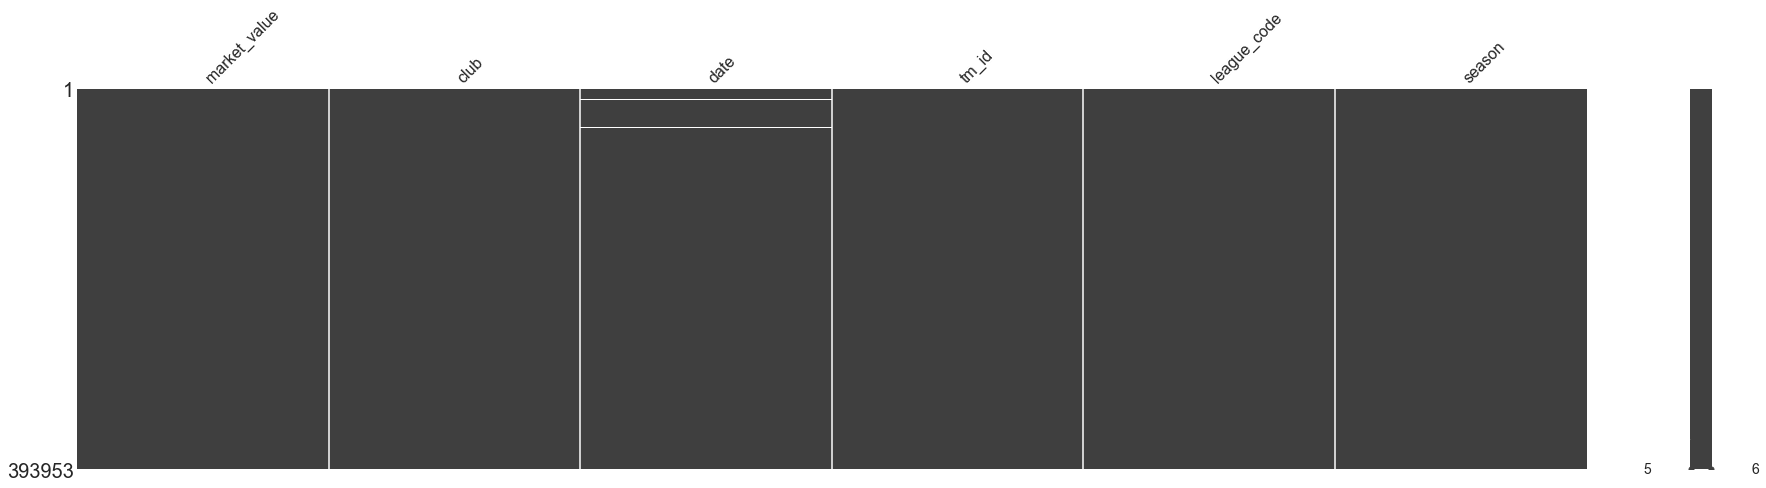

In [15]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm_market_value_raw
msno.matrix(df_tm_market_value_raw, figsize = (30, 7))

In [16]:
# Counts of missing values
tm_bio_null_value_stats = df_tm_market_value_raw.isnull().sum(axis=0)
tm_bio_null_value_stats[tm_bio_null_value_stats != 0]

date    4070
dtype: int64

The visualisation shows us very quickly that there a few missing values in most of the columns, but the dataset is ready for us.

___

<a id='section4'></a>

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Assign Raw DataFrames to New Engineered DataFrames</a>

In [17]:
# Assign Raw DataFrames to new Engineered DataFrames
df_tm_market_value = df_tm_market_value_raw.copy()

### <a id='#section4.2'>4.2. Dedupe DataFrames</a>
A copy of each player is saved per season, causing duplication if not treated.

In [19]:
df_tm_market_value = (df_tm_market_value
                          .sort_values(['season', 'tm_id', 'date'], ascending=[False, True, False])
                         #.drop(columns=['league_code', 'season'])
                          .drop_duplicates(subset=['tm_id', 'date'], keep='first')
                     )

In [21]:
print('No. rows in Historical Player Value DataFrame BEFORE deduplication: {}'.format(len(df_tm_market_value_raw)))
print('No. rows in DataFrame AFTER deduplication: {}\n'.format(len(df_tm_market_value)))
print('Variance in rows before and after deduplication: {}\n'.format(len(df_tm_market_value_raw) - len(df_tm_market_value)))
print('-'*10)

No. rows in Historical Player Value DataFrame BEFORE deduplication: 393953
No. rows in DataFrame AFTER deduplication: 140355

Variance in rows before and after deduplication: 253598

----------


In [22]:
df_tm_market_value['tm_id'].nunique()

9462

### <a id='#section4.3'>4.3. Clean Date Attribute</a>

##### Year

In [23]:
df_tm_market_value['year'] = df_tm_market_value['date'].str.split(',').str[-1].str[:5]
df_tm_market_value['year'] = pd.to_numeric(df_tm_market_value['year'], errors='coerce')
df_tm_market_value['year'] = df_tm_market_value['year'].fillna(-1).astype(int).astype(str).replace('-1', np.nan)

##### Month

In [24]:
#


##
df_tm_market_value['month'] = df_tm_market_value['date'].str.split(' ').str[0].str.replace(' ', '')


##
dict_months = {'Jan': 1,
               'Feb': 2,
               'Mar': 3,
               'Apr': 4,
               'May': 5,
               'Jun': 6,
               'Jul': 7,
               'Aug': 8,
               'Sep': 9,
               'Oct': 10,
               'Nov': 11,
               'Dec': 12
              }

## Map grouped positions to DataFrame
df_tm_market_value['month'] = df_tm_market_value['month'].map(dict_months).fillna(-1).astype(int).astype(str).replace('-1', np.nan)

##### Day

In [25]:
df_tm_market_value['day'] = df_tm_market_value['date'].str.split(' ').str[1].str[:3].str.replace(',', '')
df_tm_market_value['day'] = pd.to_numeric(df_tm_market_value['day'], errors='coerce')
df_tm_market_value['day'] = df_tm_market_value['day'].fillna(-1).astype(int).astype(str).replace('-1', np.nan)

##### Date

In [26]:
df_tm_market_value['date'] = pd.to_datetime(df_tm_market_value[['year', 'month', 'day']])

In [27]:
df_tm_market_value.shape

(140355, 9)

### <a id='#section4.4'>4.4. Keep Only One Row per Year</a>
Take the last value per year as that year's valuation. Ideally, this would be the date closest to September (start of the season), but for now, the current code is fine.

In [28]:
df_tm_market_value_grouped = (df_tm_market_value
                                  .loc[df_tm_market_value.groupby(['tm_id', 'year']).date.idxmax(axis=0, skipna=True)]
                                  .reset_index(drop=True)
                             )

In [74]:
df_tm_market_value_grouped

,market_value_eur,club,tm_id,league_code,season,market_value_gbp
0,2000000,Borussia Dortmund,26,L1,2004/2005,1800000.0
1,6750000,Borussia Dortmund,26,L1,2005/2006,6075000.0
2,7500000,Borussia Dortmund,26,L1,2006/2007,6750000.0
3,8000000,Borussia Dortmund,26,L1,2007/2008,7200000.0
4,5000000,Borussia Dortmund,26,L1,2008/2009,4500000.0
...,...,...,...,...,...,...
67231,200000,Dijon FCO,894205,FR1,2021/2022,180000.0
67232,50000,Los Angeles FC,898751,MLS1,2021/2022,45000.0
67233,25000,Atlanta United FC,900440,MLS1,2021/2022,22500.0
67234,150000,RC Lens,905408,FR1,2021/2022,135000.0


### <a id='#section4.5'>4.5. Create `season` attribute</a>

In [29]:
#

## Map season to DataFrame
df_tm_market_value_grouped['season'] = df_tm_market_value_grouped['year'].map(dict_seasons)

 ### <a id='#section4.6'>4.6. Drop columns</a>
Drop `date`, `year`, `month`, and `day`

In [30]:
df_tm_market_value_grouped = df_tm_market_value_grouped.drop(['date', 'year', 'month', 'day'], axis=1)

### <a id='#section4.7'>4.7. Rename Columns</a>

In [31]:
df_tm_market_value_grouped = df_tm_market_value_grouped.rename(columns={'market_value': 'market_value_eur'})

### <a id='#section4.8'>4.8. Convert `market_value` to Pounds</a>

In [32]:
# Get EUR to GBP exchange rate

## Get latest currency rates
c = CurrencyConverter()

##  Get conversion rate from EUR to GBP
rate_eur_gbp = (c.convert(1, 'EUR', 'GBP'))
rate_eur_gbp

0.90053

In [33]:
# Overwrite
rate_eur_gbp = 0.90
rate_eur_gbp

0.9

In [34]:
df_tm_market_value_grouped['market_value_gbp'] = df_tm_market_value_grouped['market_value_eur'] * rate_eur_gbp

In [35]:
df_tm_market_value_grouped

,market_value_eur,club,tm_id,league_code,season,market_value_gbp
0,2000000,Borussia Dortmund,26,L1,2004/2005,1800000.0
1,6750000,Borussia Dortmund,26,L1,2005/2006,6075000.0
2,7500000,Borussia Dortmund,26,L1,2006/2007,6750000.0
3,8000000,Borussia Dortmund,26,L1,2007/2008,7200000.0
4,5000000,Borussia Dortmund,26,L1,2008/2009,4500000.0
...,...,...,...,...,...,...
67231,200000,Dijon FCO,894205,FR1,2021/2022,180000.0
67232,50000,Los Angeles FC,898751,MLS1,2021/2022,45000.0
67233,25000,Atlanta United FC,900440,MLS1,2021/2022,22500.0
67234,150000,RC Lens,905408,FR1,2021/2022,135000.0


### <a id='#section4.9'>4.9. Join Bio-Status Dataset</a>

#### Read in Engineering Bio-Status DataFrame

In [36]:
# Import DataFrame as a CSV file
df_tm_bio_status = pd.read_csv(data_dir_tm + f'/engineered/bio-status/tm_player_bio_status_all_1617-2122_latest.csv')

#### Filter DataFrame for 'Big 5' European Leagues and MLS Players

In [37]:
# Filter playerss in the 'Big 5' European Leagues and MLS
df_tm_bio_status_big5_mls = df_tm_bio_status[df_tm_bio_status['league_code'].isin(lst_big5_mls_league_codes)]

In [38]:
print('No. rows in DataFrame BEFORE filtration: {}'.format(len(df_tm_bio_status)))
print('No. rows in DataFrame AFTER filtration: {}\n'.format(len(df_tm_bio_status_big5_mls)))
print('Variance in rows before and after filtration: {}\n'.format(len(df_tm_bio_status_big5_mls) - len(df_tm_bio_status)))
print('-'*10)

No. rows in DataFrame BEFORE filtration: 9429
No. rows in DataFrame AFTER filtration: 9429

Variance in rows before and after filtration: 0

----------


#### Drop `league_code` and  `season` columns

In [39]:
df_tm_bio_status = df_tm_bio_status.drop(columns=['league_code', 'season', 'market_value_gbp', 'market_value_eur'])
df_tm_bio_status_big5_mls = df_tm_bio_status_big5_mls.drop(columns=['league_code', 'season', 'market_value_gbp', 'market_value_eur'])

#### Join the Bio Status DataFrame to the Historical Market Value DataFrame

In [40]:
# Join the Bio-Status DataFrame to the Market Value DataFrame to form one, unified DataFrame
df_tm_market_value_bio_status = pd.merge(df_tm_market_value_grouped, df_tm_bio_status, left_on='tm_id', right_on='tm_id', how='left')

In [41]:
print('No. rows in Market Value DataFrame BEFORE join to Bio-Status data: {}'.format(len(df_tm_market_value_grouped)))
print('No. rows in DataFrame AFTER join: {}\n'.format(len(df_tm_market_value_bio_status)))
print('Variance in rows before and after join: {}\n'.format(len(df_tm_market_value_grouped) - len(df_tm_market_value_bio_status)))
print('-'*10)

No. rows in Market Value DataFrame BEFORE join to Bio-Status data: 67236
No. rows in DataFrame AFTER join: 67236

Variance in rows before and after join: 0

----------


In [42]:
df_tm_market_value_bio_status.shape

(67236, 41)

### <a id='#section4.10'>4.10. Rename Columns</a>

In [49]:
df_tm_market_value_bio_status = df_tm_market_value_bio_status.rename(columns={'age': 'current_age'})

### <a id='#section4.11'>4.11. Select Columns of Interest</a>

In [77]:
## Define columns
cols = ['tm_id',
        'season',
        'player_name',
        'club',
        'current_club',
        'league_code',
        'current_age',
        'market_value_gbp',
        'market_value_eur',
        'dob',
        'pob',
        'birth_year',
        'position',
        'position_code',
        'position_grouped',
        'outfielder_goalkeeper',
        'height',
        'foot',
        'citizenship',
        'second_citizenship',
        'player_agent'
       ]

## Select columns of interest
df_tm_market_value_bio_status_select = df_tm_market_value_bio_status[cols]

## Sort by 'tm_id' and 'season' ascending
df_tm_market_value_bio_status_select = df_tm_market_value_bio_status_select.sort_values(['tm_id', 'season'], ascending=[True, True])

## Drop index
df_tm_market_value_bio_status_select = df_tm_market_value_bio_status_select.reset_index(drop=True)

## Drop duplicates
df_tm_market_value_bio_status_select = df_tm_market_value_bio_status_select.drop_duplicates()

## Display DataFrame
df_tm_market_value_bio_status_select.head(10)

,tm_id,season,player_name,club,current_club,league_code,current_age,market_value_gbp,market_value_eur,dob,pob,birth_year,position,position_code,position_grouped,outfielder_goalkeeper,height,foot,citizenship,second_citizenship,player_agent
0,26,2004/2005,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,1800000.0,2000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
1,26,2005/2006,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,6075000.0,6750000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
2,26,2006/2007,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,6750000.0,7500000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
3,26,2007/2008,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,7200000.0,8000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
4,26,2008/2009,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,4500000.0,5000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
5,26,2010/2011,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,4050000.0,4500000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
6,26,2011/2012,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,4500000.0,5000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
7,26,2012/2013,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,4500000.0,5000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
8,26,2013/2014,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,4500000.0,5000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
9,26,2014/2015,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,4500000.0,5000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer


### <a id='#section4.12'>4.12. Determine Retired Players</a>

In [78]:
# determine current season from today's date
# if season does not appear in the dataset, they've retired - is retired attribute

In [79]:
# add other attributes
# current age / age of season - see TM Bio Status ntb for how to calculate some of these
# current club / club of season
# add 'current' to the following: contract_expires, contract_option, on_loan_from, on_loan_from_country, loan_contract_expiry

In [80]:
## DOUBLE CHECK ATTRIBUTES SELECTED IN FINAL DATASET

### <a id='#section4.13'>4.13. Filter Players in 'Big 5' European Leagues</a>
Export the engineered DataFrame as a CSV file.

In [81]:
# Filter playerss in the 'Big 5' European Leagues and MLS
df_tm_market_value_bio_status_select_big5_mls = df_tm_market_value_bio_status_select[df_tm_market_value_bio_status_select['league_code'].isin(lst_big5_mls_league_codes)]

In [82]:
print('No. rows in DataFrame BEFORE filtration: {}'.format(len(df_tm_market_value_bio_status_select)))
print('No. rows in DataFrame AFTER filtration: {}\n'.format(len(df_tm_market_value_bio_status_select_big5_mls)))
print('Variance in rows before and after filtration: {}\n'.format(len(df_tm_market_value_bio_status_select) - len(df_tm_market_value_bio_status_select_big5_mls)))
print('-'*10)

No. rows in DataFrame BEFORE filtration: 67236
No. rows in DataFrame AFTER filtration: 67236

Variance in rows before and after filtration: 0

----------


### <a id='#section4.14'>4.14. Exporting the Engineered DataFrames</a>
Export the engineered DataFrame as a CSV file.

##### All players

In [83]:
## Filename
file_name = 'tm_player_valuations_all'

## Full season string
full_season_string = '2016/2017-2021/2022'

## Short season string
short_season_string = '1617-2122'

In [84]:
# Export DataFrame as a CSV file

## Export a copy to the 'archive' subfolder of the TM folder, including the date
df_tm_market_value_bio_status_select.to_csv(data_dir_tm + f'/engineered/historical_market_values/archive/{file_name}_{short_season_string}_last_updated_{today}.csv', index=None, header=True)

## Export another copy to the TM folder called 'latest' (can be overwritten)
df_tm_market_value_bio_status_select.to_csv(data_dir_tm + f'/engineered/historical_market_values/{file_name}_{short_season_string}_latest.csv', index=None, header=True)

##### 'Big 5' European and MLS Players

In [85]:
## Filename
file_name = 'tm_player_valuations_big5_mls'

## Full season string
full_season_string = '2016/2017-2021/2022'

## Short season string
short_season_string = '1617-2122'

In [86]:
## 'Big 5' European Leagues and MLS

### Export a copy to the 'archive' subfolder of the TM folder, including the date
df_tm_market_value_bio_status_select_big5_mls.to_csv(data_dir_tm + f'/engineered/historical_market_values/archive/tm_bio_status_big5_mls_{short_season_string}_last_updated_{today}.csv', index=None, header=True)

### Export another copy to the TM folder called 'latest' (can be overwritten)
df_tm_market_value_bio_status_select_big5_mls.to_csv(data_dir_tm + f'/engineered/historical_market_values/tm_bio_status_big5_mls_{short_season_string}_latest.csv', index=None, header=True)

___

<a id='section5'></a>

## <a id='#section5'>5. Exploratory Data Analysis</a>

In [87]:
df_tm_market_value_bio_status_select.head()

,tm_id,season,player_name,club,current_club,league_code,current_age,market_value_gbp,market_value_eur,dob,pob,birth_year,position,position_code,position_grouped,outfielder_goalkeeper,height,foot,citizenship,second_citizenship,player_agent
0,26,2004/2005,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,1800000.0,2000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
1,26,2005/2006,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,6075000.0,6750000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
2,26,2006/2007,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,6750000.0,7500000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
3,26,2007/2008,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,7200000.0,8000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer
4,26,2008/2009,roman weidenfeller,Borussia Dortmund,retired,L1,41.0,4500000.0,5000000,1980-08-06,Diez,1980.0,Goalkeeper,GK,Goalkeeper,Goalkeeper,188.0,left,Germany,NaN,Jörg Neubauer


___

<a id='section6'></a>

## <a id='#section6'>6. Summary</a>
This Jupyter notebook engineered scraped football data from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

___

<a id='section7'></a>

## <a id='#section7'>7. Next Steps</a>
The step is to use this data and match it to FBref, 21st Club, Opta, FIFA, and other datasets.

___

<a id='section8'></a>

## <a id='#section8'>8. References</a>

#### Data and Web Scraping
*    [tyrone_mings GitHub repository](https://github.com/FCrSTATS/tyrone_mings) by [FCrSTATS](https://github.com/FCrSTATS)
*    [Python Package Index (PyPI) tyrone-mings library](https://pypi.org/project/tyrone-mings/)
*    [Beyond crowd judgments: Data-driven estimation of market value in association football](https://www.sciencedirect.com/science/article/pii/S0377221717304332) by Oliver Müllera, Alexander Simons, and Markus Weinmann.
*    [06/04/2020: BBC - Premier League squads 'drop £1.6bn in value'](https://www.bbc.co.uk/sport/football/52221463).

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)